In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM

%matplotlib inline

In [6]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

cloud_path = '/content/drive/MyDrive/Colab Notebooks/'

df = pd.read_csv(cloud_path + "kddcup.data.corrected", sep=",", names=columns, index_col=None)

In [7]:
df = df[df["service"] == 'http']
df = df.drop("service", axis = 1)
columns.remove("service")

In [8]:
novelties = df[df["label"] != "normal."]
novelties_normal = df[150000:154045]

novelties = pd.concat([novelties, novelties_normal])
normal = df[df["label"] == "normal."]

In [9]:
print(novelties.shape)
print(normal.shape)

(8090, 41)
(619046, 41)


In [10]:
for col in normal.columns:
  if normal[col].dtype == "object":
    encoded = LabelEncoder()
    encoded.fit(normal[col])
    normal[col] = encoded.transform(normal[col])

for col in novelties.columns:
  if novelties[col].dtype == "object":
    encoded2 = LabelEncoder()
    encoded2.fit(novelties[col])
    novelties[col] = encoded2.transform(novelties[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
for f in range(0, 10):
  normal = normal.iloc[np.random.permutation(len(normal))]

df2 = pd.concat([normal[:100000], normal[200000:250000]])

df_validate = normal[100000:150000]

x_train, x_test = train_test_split(df2, test_size = 0.2, random_state = 42)
x_val = df_validate

In [15]:
print("Shape:\nx_train:{}\n".format(x_train.shape))
print("x_test:{}\n".format(x_test.shape))
print("x_val:{}\n".format(x_val.shape))

Shape:
x_train:(120000, 41)

x_test:(30000, 41)

x_val:(50000, 41)



In [21]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005, nu = 0.1)
#버전문제인지 random_state가 안먹는다, 일단 random_state 없이 돌려보자
#kernel : radial basis function
#gammma : 모델이 hyperplane과 얼마나 떨어져있는지를 보는 것
#nu : 


In [22]:
ocsvm.fit(x_train)

OneClassSVM(gamma=5e-05, nu=0.1)

In [23]:
preds = ocsvm.predict(x_test)
score = 0
for f in range(0, x_test.shape[0]):
  if(preds[f] == 1):
    score = score + 1

accuracy = score / x_test.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

#test 셋의 정확도 검증 

Accuracy: 89.17%


In [24]:
preds = ocsvm.predict(x_val)
score = 0
for f in range(0, x_val.shape[0]):
  if(preds[f] == 1):
    score = score + 1

accuracy = score / x_val.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

#val 셋의 정확도 검증

Accuracy: 89.13%


# AUC 살펴보기

In [25]:
from sklearn.metrics import roc_auc_score

preds = ocsvm.predict(novelties)
matches = novelties["label"] == 4

auc = roc_auc_score(preds, matches)
print("AUC: {:.2%}".format(auc))

AUC: 95.90%


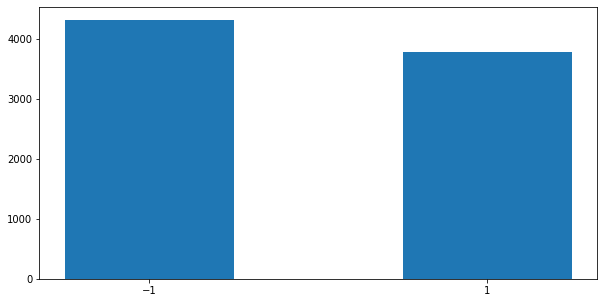

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins = [-1.5, -0.5] + [0.5, 1.5], align = 'mid')
plt.xticks([-1, 1])
plt.show()

1은 정상 데이터 -1 은 비정상데이터를 나타낸다